In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn.model_selection import StratifiedKFold

SyntaxError: invalid syntax (basic.py, line 44)

In [21]:
train_data = pd.read_csv('./data/Bank/train_public.csv')
submit_example = pd.read_csv('./data/Bank/submit_example.csv')
test_public = pd.read_csv('./data/Bank/test_public.csv')
pd.set_option('max_columns', None)
pd.set_option('max_rows', 200)
pd.set_option('float_format', lambda x: '%.3f' % x)

In [22]:
train_data.info

<bound method DataFrame.info of       loan_id  user_id  total_loan  year_of_loan  interest  monthly_payment  \
0     1040418   240418   31818.182             3    11.466         1174.910   
1     1025197   225197   28000.000             5    16.841          670.690   
2     1009360   209360   17272.727             3     8.900          603.320   
3     1039708   239708   20000.000             3     4.788          602.300   
4     1027483   227483   15272.727             3    12.790          470.310   
5     1047529   247529   25454.545             3    10.637          899.150   
6     1030964   230964    9090.909             5    15.741          234.300   
7     1024822   224822   10288.636             3    11.490          414.620   
8     1008720   208720    6818.182             3    20.064          272.050   
9     1045305   245305   10800.000             3    14.330          339.950   
10    1007760   207760   14727.273             5    12.897          421.920   
11    1042906   2429

In [10]:
def train_model(data_, test_, y_, folds_):
    oof_preds = np.zeros(data_.shape[0])
    sub_preds = np.zeros(test_.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in data_.columns if f not in ['loan_id', 'user_id', 'isDefault'] ]
#     for n_fold, (trn_idx, val_idx) in enumerate(folds_.split(data_,y_)):
    for n_fold, (trn_idx, val_idx) in enumerate(folds_.split(data_)):
        trn_x, trn_y = data_[feats].iloc[trn_idx], y_.iloc[trn_idx]
        val_x, val_y = data_[feats].iloc[val_idx], y_.iloc[val_idx]
        clf = LGBMClassifier(
            n_estimators=4000,
            learning_rate=0.08,
            num_leaves=2**5,
            colsample_bytree=.65,
            subsample=.9,
            max_depth=5,
            reg_alpha=.3,
            reg_lambda=.3,
            min_split_gain=.01,
            min_child_weight=2,
            silent=-1,
            verbose=-1,
        )
        
        clf.fit(trn_x, trn_y, 
                eval_set= [(trn_x, trn_y), (val_x, val_y)], 
                eval_metric='auc', verbose=100, early_stopping_rounds=40  #30
               )

        oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_[feats], num_iteration=clf.best_iteration_)[:, 1] / folds_.n_splits
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
        del clf, trn_x, trn_y, val_x, val_y
        gc.collect()
        
    print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 
    
    test_['isDefault'] = sub_preds

    return oof_preds, test_[['loan_id', 'isDefault']], feature_importance_df
    
def display_importances(feature_importance_df_):
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')

In [11]:
train_data.head()

NameError: name 'train_data' is not defined

In [12]:
check_psi = ['year_of_loan',
'class',
'employer_type',
'industry',
'work_year',
'house_exist',
'censor_status',
'known_outstanding_loan',
'use',
'post_code',
'region',
'del_in_18month',
'known_dero',
'policy_code',
'early_return']
for col in check_psi:
    count_tr = col+'_count_trn'
    count_te = col+'_count_tst'
    df1 = train_data[col].value_counts(normalize=True).to_frame().reset_index().rename({'index':col,col:count_tr}, axis=1)
    df2 = test_public[col].value_counts(normalize=True).to_frame().reset_index().rename({'index':col,col:count_te}, axis=1)
    df1 = df1.merge(df2,on=col,how='left')
    df1['ratio'] = df1[count_tr]/df1[count_te]
    df1['ln_ratio'] = np.exp(df1['ratio'] )
    df1['change'] = df1[count_tr]-df1[count_te]
    df1['psi_cell'] = df1['ln_ratio']*df1['change']
    print(col+' psi '+str(df1['psi_cell'].sum()))

NameError: name 'train_data' is not defined

NameError: name 'train_data' is not defined

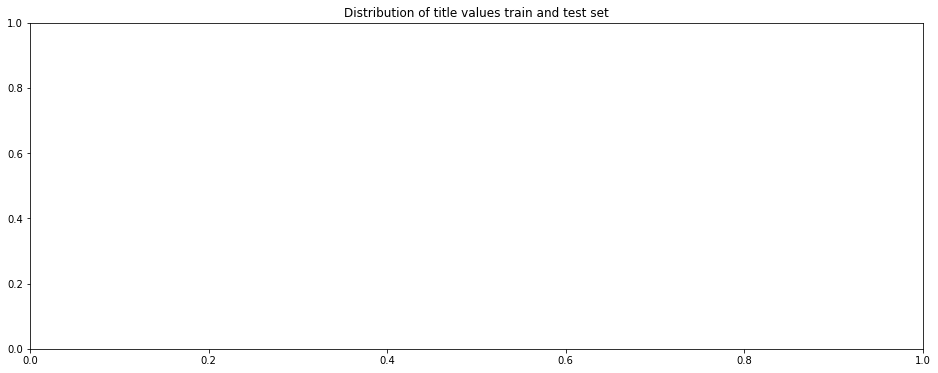

In [13]:
plt.figure(figsize=(16,6))
plt.title("Distribution of title values train and test set")
sns.distplot(train_data['post_code'],color="black", kde=True,bins=120, label='train')
sns.distplot(test_public['post_code'],color="red", kde=True,bins=120, label='test')
plt.legend();plt.show()

In [14]:
train_data['post_code_to_mean_interst'] = train_data.groupby(['post_code'])['interest'].transform('mean')

plt.figure(figsize=(16,6))
plt.title("Distribution of title values train and test set")
sns.distplot(train_data.loc[train_data.isDefault==1,'post_code_to_mean_interst'],color="black", kde=True,bins=120, label='Frault')
sns.distplot(train_data.loc[train_data.isDefault==0,'post_code_to_mean_interst'],color="red", kde=True,bins=120, label='not Frault')
plt.legend();plt.show()

NameError: name 'train_data' is not defined

In [15]:
work_year_dict = {
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10,
}

train_data['work_year'] = train_data['work_year'].map(work_year_dict)
test_public['work_year'] = test_public['work_year'].map(work_year_dict)
train_data['work_year'] = train_data['work_year'].fillna(-1)
test_public['work_year'] = test_public['work_year'].fillna(-1)


class_dict = {
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7,
}

train_data['class'] = train_data['class'].map(class_dict)
test_public['class'] = test_public['class'].map(class_dict)

train_data['issue_date'] = pd.to_datetime(train_data['issue_date'])
test_public['issue_date'] = pd.to_datetime(test_public['issue_date'])


train_data['issue_date_month'] = train_data['issue_date'].dt.month
test_public['issue_date_month'] = train_data['issue_date'].dt.month

train_data['issue_date_dayofweek'] = train_data['issue_date'].dt.dayofweek
test_public['issue_date_dayofweek'] = train_data['issue_date'].dt.dayofweek


col_to_drop = ['issue_date', 'earlies_credit_mon']
train_data = train_data.drop(col_to_drop, axis=1)
test_public = test_public.drop(col_to_drop, axis=1)

cat_cols = ['employer_type', 'industry']

from sklearn.preprocessing import LabelEncoder
for col in cat_cols:
    lbl = LabelEncoder().fit(train_data[col])
    train_data[col] = lbl.transform(train_data[col])
    test_public[col] = lbl.transform(test_public[col])

NameError: name 'train_data' is not defined

In [16]:
train_data['post_code_to_mean_interst'] = train_data.groupby(['post_code'])['interest'].transform('mean')
test_public['post_code_to_mean_interst'] = test_public.groupby(['post_code'])['interest'].transform('mean')
train_data['post_code_cnt'] = train_data['post_code'].map(train_data['post_code'].value_counts())
train_data.loc[train_data['post_code_cnt']<=5,'post_code_to_mean_interst'] = np.nan
del train_data['post_code_cnt']
test_public['post_code_cnt'] = test_public['post_code'].map(test_public['post_code'].value_counts())
test_public.loc[test_public['post_code_cnt']<=5,'post_code_to_mean_interst'] = np.nan
del test_public['post_code_cnt']

NameError: name 'train_data' is not defined

In [17]:
data = pd.concat( [train_data,test_public] )

for col in numOfVal:
    dum = pd.get_dummies(data[col], prefix='OneHot_'+col +'_')
    data = pd.concat([data, dum], axis=1)
    del dum

NameError: name 'train_data' is not defined

In [18]:
train = data[data['isDefault'].notna()]
test  = data[data['isDefault'].isna()]
y = train['isDefault']
del data
del train_data,test_public
folds = KFold(n_splits=10, shuffle=True, random_state=seed)
oof_preds, test_preds, importances = train_model(train, test, y, folds)

NameError: name 'data' is not defined

In [19]:
test_preds.rename({'loan_id': 'id'}, axis=1)[['id', 'isDefault']].to_csv('submit/Fraut_Ver20210926_01.csv', index=False)

NameError: name 'test_preds' is not defined